# Introduction

XGBoost is a widely used machine learning library. We optimized its performance for distributed training on Spark clusters with Intel Xeon CPUs and get 21x performance speedup of the load and conversion time. You can find the optimizations here:  We are in the process to upstream our optimizations to XGBoost.

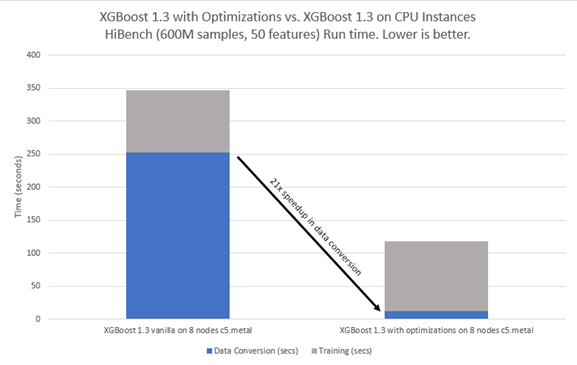

This notebook walks through steps of using Intel optimized XGBoost on a Spark cluster. The following steps are verified on AWS instances using:

* Ubuntu 18.04
* Apache Spark 3.0
* Apache Hadoop 2.7
* Scala 2.12
* Python 3.8

If your environment is different then you must adjust accordingly, but these steps are still applicable in general.

# Optimizations

Compared xgboost0.8, community has optimized the xgboost training performance a lot. But spark's distributed training implementation on xgboost is still inefficient, which leads to even longer data load and conversion time than the training itself even we just load the dataset from parquet files, as shown in above chart.

There are two issues in current implementation:
Firstly to enable the OMP training, Spark needs to set task.cpus to nThreads, which leads to the data load and conversion run in single thread in each executor, as shown in below chart. If we set nThread to 1, we disabled the OMP optimizations during training.
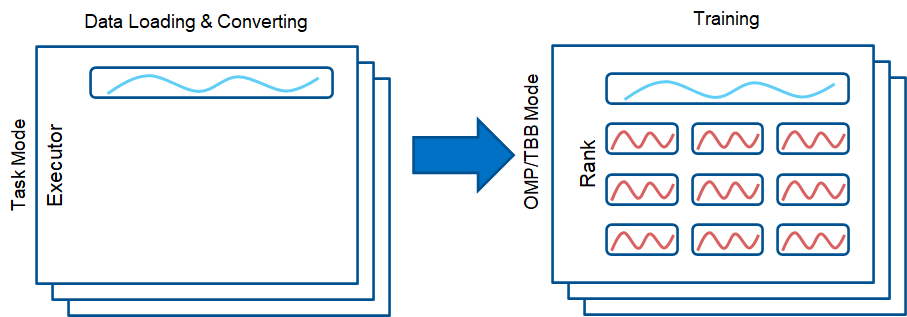

The solution is to enable Spark3.1's stage level resource management to set the task.cpus dynamically so we can enable the task mode during data loading and conversion and OMP mode during training. Our implementation so far doesn't use this way because it's still not ready when we optimize it. Instead we concatenate the DMatrixes in the same executor into single large DMatrix and set its prefer_location to this executor. So Spark scheduler will schedule the training task to this executor. During concatenation we cache the pointer of small dmatrix and then merge the small ones into large one which leads to one memcpy. We are working to use Spark3.1's stage level resource management to solve the issue. In this way we can utilize all CPUs during data preparing and training as shown in below chart:
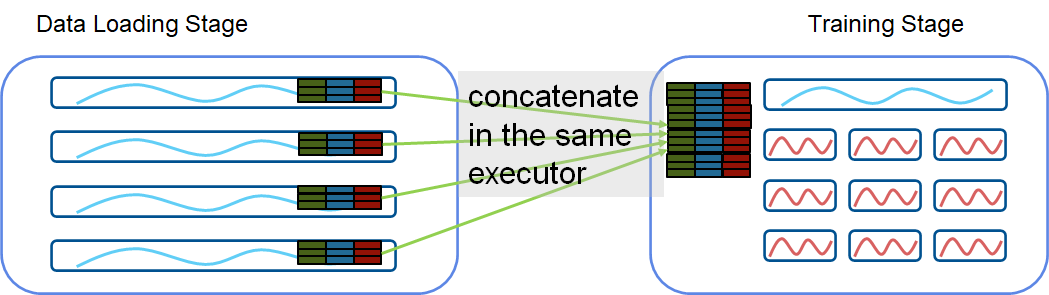

The second issue is that data conversion from Spark to DMatrix is too complex today. Firstly we need to transform dataset by VectorAssembler in ML pipeline. Then in side of xgboost, data is converted as ArrayList[LabeledPoint]. Then it's copied to offheap and convert to DMatrix. The conversion is too time consuming. It also use much JVM memory which may not be released by GC quickly enough before training start. The training stage in xgboost is memory consuming. The solution is to use Spark's columnar API to convert dataset to DMatrix directly. In our optimization, we integrate with our Native Arrow data source of Native SQL engine project, we can implement the whole conversion in offheap memory and achieve zero-copy. So we can boost the performance to best. As shown in below chart
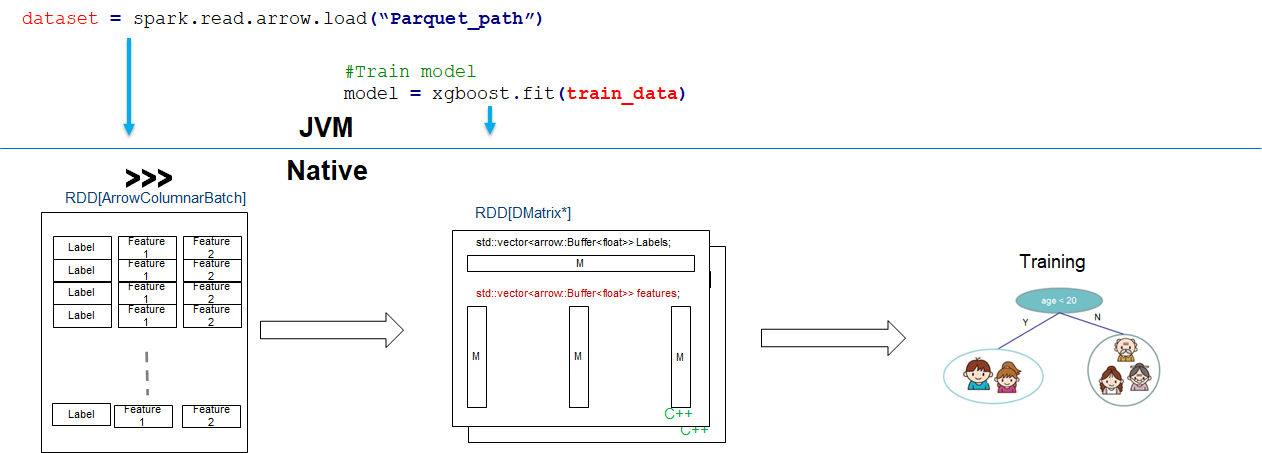


<b> Our on-going work:</b>
<ol>
	<li>Add arrow to DMatrix conversion to XGBoost c++ but remove the arrow library dependency. We will use arrow&#39;s C interface</li>
	<li>Add stage level resource management. Enable multiple thread during data loading and training</li>
	<li>Add Columnar to DMatrix conversion using Spark3.0&#39;s columnar API. If spark load dataset from parquet file, it can convert to DMatrix directly</li>
</ol>

# Build XGBoost

This section describes build instructions specific to the Intel optimized XGBoost. For general building instructions, refere to the [official documentation](https://xgboost.readthedocs.io/en/latest/build.html).

First, make sure to clone the correct version of XGBoost from the Intel BigData repo:

```bash
git clone https://github.com/Intel-bigdata/xgboost.git -b arrow-to-dmatrix
```

Then, the easiest way to build is to do it in a `conda` environment, where we can install all required dependencies and build tools. 

```bash
conda install pyarrow=3.0.* maven git cmake -c conda-forge
```

We need to set the `ARROW_HOME` and `LD_LIBRARY_PATH` environment variables:

```bash
export ARROW_HOME=$CONDA_PREFIX
export LD_LIBRARY_PATH=$ARROW_HOME:$LD_LIBRARY_PATH
```

Finally, build the XGBoost jar files:

```bash
cd xgboost/jvm-packages
mvn -DskipTests clean package
```

You can get the `xgboost*.jar` and `xgboost-spark*.jar` in `./xgboost4j-spark/target/` and `./xgboost4j/target/` paths.

# Generate data used in this example

## Install HiBench

We use a synthetic dataset generated using the [HiBench](https://github.com/Intel-bigdata/HiBench)

If you don't have HiBench installed, you can download it with

```bash
git clone https://github.com/Intel-bigdata/HiBench.git
```

Then use this command to build it:

```bash
mvn -Dhadoop=2.7. -Dspark=3.0 -Dscala=2.12 -DskipTests clean package
```

Refer to the [documentation](https://github.com/Intel-bigdata/HiBench/blob/master/docs/build-hibench.md) for more detailed instructions.

## Generate a random dataset to test classification

We use HiBench to generate a large bi-class dataset. Later, we will use this dataset to train a classification model. Follow these steps:

* Assume HiBench is installed in a location pointed by `$HIBENCH_INSTALL`, first we need to configure HiBench to work with our Hadoop cluster. Modify the a few options in file `$HIBENCH_INSTALL/conf/hadoop.conf` to allow HiBench to be able to find Hadoop.

* Then we need to set a few configuration options to specify the number of features and samples. Edit file `$HIBENCH_INSTALL/conf/workloads/ml/xgboost.conf` to contain these two lines: (Modify these numbers to better suit your cluster)

```bash
hibench.xgboost.custom.examples             606000000
hibench.xgboost.custom.features             50
```

* Tell HiBench to respect our specifications by changing `hibench.scale.profile` value in file `$HIBENCH_INSTALL/conf/hibench.conf`:

```bash
hibench.scale.profile                custom
```

* Now we are ready to generate the data in raw format. From location `$HIBENCH_INSTALL`, run

```bash
./bin/workloads/ml/xgboost/prepare/prepare.sh
```

* Finally, we convert the raw data to parquet format. A [simple notebook](./spylon-hibenchdata-to-parquet.ipynb) is provided for this purpose. **Note: This notebook requires [spylon-kernel](https://pypi.org/project/spylon-kernel/). Make sure it is installed before you run the notebook.** The conversion notebook reads raw data generated in the previous step, which is found in HDFS folder ``/HiBench/XGBoost/Input``, and outputs parquet files into HDFS folder `/HiBench606Mx50.dataframe.float.parquet`.

The label column of the dataset is conveniently named $label$, and the feature columns are named $f0, f1, ..., f49$.


# XGBoost jar files and Arrow Data Source plugin

To run this example, we need the following ingredients:
* XGBoost jar files: `xgboost4j_2.12-1.3.3.jar` and `xgboost4j-spark_2.12-1.3.3.jar`. They can be built from source as described above, or can be downloaded from https://repo1.maven.org/maven2/com/intel/bigdata/xgboost
* The OAP data source jar that enables reading input data into the Arrow in-memory representation: `spark-arrow-datasource-1.1.0-jar-with-dependencies.jar`. Follow [OAP datasource documentation](https://github.com/Intel-bigdata/OAP/tree/master/oap-data-source) to build it, or download it from https://repo1.maven.org/maven2/com/intel/oap/spark-arrow-datasource-standard/1.1.0/
* A PySpark wrapper for XGBoost: `sparkxgb_1.24.zip`. This file is found in the source package, located in path `xgboost/jvm-packages/xgboost4j-spark/contrib/sparkxgb_1.24.zip`

In [1]:
import os
from pathlib import Path

# Get $HOME
home = str(Path.home())

# $SPARK_HOME
spark_home = '/home/ubuntu/spark-3.0.0-bin-hadoop2.7'

# XGBoost jars and dependencies
path_to_jars = f'{home}/xgboost_jars/'
arrow_datasource_jar_name = 'spark-arrow-datasource-standard-1.1.0-jar-with-dependencies.jar'
arrow_datasource_jar = path_to_jars + arrow_datasource_jar_name
xgboost4j_jar = path_to_jars + 'xgboost4j_2.12-1.3.3.jar'
xgboost4j_spark_jar = path_to_jars + 'xgboost4j-spark_2.12-1.3.3.jar'
sparkxgb_zip = path_to_jars + 'sparkxgb_1.24.zip'

The jar files are passed with the `--jars` flag of the PySpark submit command, followed by PySpark initialization:

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars ' + ','.join([xgboost4j_jar, xgboost4j_spark_jar, arrow_datasource_jar]) + ' pyspark-shell'
os.environ['LD_LIBRARY_PATH'] = '/home/ubuntu/miniconda3/lib'

import findspark
findspark.init(spark_home)

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession


# Initialize the Spark cluster

Adjust cluster size to suit your situation:

In [3]:
nodes = 4
executors_per_node = 4
cores_per_executor = 24

Next, start the Spark cluster. Among available Spark config options, a few are critical to successfully running this example:

* `spark.task.cpus`. <span style="color:#c0392b"><strong>This option must be set to 1</strong></span>. Our optimization merges DMatrices created by all tasks on the same executor into a single DMatrix to better exploit OpenMP parallelism. During training there will only be one task per exeuctor running. Setting this option to a value more than 1 will cause oversubscription problem.
* `spark.driver.extraClassPath`. This option must be set to the path on the driver where the OAP datsource jar can be found.
* `spark.executor.extraClassPath`. This option must be set, for every executor, to the path where the OAP datasource jar can be found. In the last step, we used `--jars` to specify all jar files, including the OAP datasource jar, to be passed to all executors. This option should be set to the working directory of the executors.
* `spark.executorEnv.LD_LIBRARY_PATH`. This option is to tell executors where to find Apache Arrow native libs. The easiest way is to create a same `conda` environment on all executors and install Arrow in this environment. For example,

```bash
conda create -n arrow pyarrow=3.0.* -c conda-forge
```

If you are reading input from AWS S3 buckets then make sure to specify your AWS access key ID and AWS secret key on all executors by setting these env variables: `spark.executorEnv.AWS_ACCESS_KEY_ID` and `spark.executorEnv.AWS_SECRET_ACCESS_KEY`.

Note we add the PySpark wrapper for XGBoost to `SparkContext`.

In [4]:
conf = (SparkConf()
        .set('spark.default.parallelism', '{:d}'.format(nodes*executors_per_node*cores_per_executor))
        .set('spark.app.name', 'XGBoost Example')
        .set('spark.rdd.compress', 'False')
        .set('spark.serializer','org.apache.spark.serializer.KryoSerializer')
        .set('spark.files.maxPartitionBytes', '512m')
        .set('spark.driver.memory','10g')
        .set('spark.executor.instances', '{:d}'.format(executors_per_node*nodes))
        .set('spark.executor.cores','{:d}'.format(cores_per_executor))
        .set('spark.executor.memory', '40g')
        .set('spark.executor.memoryOverhead','4g') 
        .set('spark.task.cpus','1') # key setting for arrow loading patch !!!
        .set('spark.memory.offHeap.enabled','True')
        .set('spark.memory.offHeap.size','4g')
        .set('spark.executor.extraJavaOptions', '-XX:+UseParallelGC -XX:+UseParallelOldGC -verbose:gc -XX:+PrintGCDetails') 
        .set('spark.driver.maxResultSize', 0)
        .set('spark.driver.extraClassPath', arrow_datasource_jar) # key setting for arrow loading patch !!!
        .set('spark.executor.extraClassPath', './'+arrow_datasource_jar_name) # key setting for arrow loading patch !!!
        .set('spark.executorEnv.LD_LIBRARY_PATH', '/home/ubuntu/anaconda3/envs/arrow/lib') # key setting for arrow loading patch !!!
        .set('spark.executorEnv.AWS_ACCESS_KEY_ID', 'xxxxxxxxxx')
        .set('spark.executorEnv.AWS_SECRET_ACCESS_KEY', 'xxxxxxxxxx'))

spark = SparkSession.builder.master('yarn').config(conf=conf).getOrCreate()
sc = spark.sparkContext
#hadoopConf = sc._jsc.hadoopConfiguration()
#hadoopConf.set('fs.s3a.endpoint', 's3.amazonaws.com')
#hadoopConf.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
sc.setLogLevel('INFO')
sc.addPyFile(sparkxgb_zip)

# Set XGBoost parameters

Here is a minimum set of parameters for XGBoost training. For good training performance, using `hist` for `treeMethod`, `depthwise` for `growPolicy`, and setting `singlePrecisionHistogram` to `True` are essencial. The `labelCol` parameter specifies the label column name. The `featuresCols` parameter is a list of columns used as features for training. If not given, then all columns other than the label column are used for training. 

We will use these parameters to initialize a `XGBoostClassifier` for training, see below. 

In [5]:
params = {'labelCol': 'label',  #"label"
          'numRound': 100,
          'treeMethod': 'hist',
          'growPolicy': 'depthwise',  
          'singlePrecisionHistogram':True,
          'numWorkers': executors_per_node*nodes,
          'nthread':cores_per_executor
         }

# Load data

Reading data using the `arrow` format allows us to leverage Arrow's columnar data format to build XGBoost DMatrix directly from it. Reading data in `arrow` format is facilitated by the OAP datasource jar. 

**Note**: We do NOT need to use `VectorAssembler` to assemble feature columns into a vector.

In [6]:
train_df = spark.read.format('arrow').load('s3a://data/HiBench606Mx50.dataframe.float.parquet')

# Training

In [7]:
from sparkxgb import XGBoostClassifier, XGBoostClassificationModel
xgboost =  XGBoostClassifier(**params)
model = xgboost.fit(train_df)
model.write().overwrite().save('/model/')
loaded_model = XGBoostClassificationModel().load('/model/')

******** XGBoostClassificationModel ********


# Inference

We can then use the trained model to do predictions on a new dataset.

In [8]:
test_df = spark.read.format('arrow').load('s3a://data/HiBench10Kx50.dataframe.float.parquet')
loaded_model.transform(test_df).select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  1.0|[-0.6301044821739...|[0.36989551782608...|       1.0|
|  1.0|[-0.5651277303695...|[0.43487226963043...|       1.0|
|  0.0|[-0.1440751701593...|[0.85592482984066...|       0.0|
|  1.0|[-0.9592475891113...|[0.04075241088867...|       1.0|
|  1.0|[-0.5073006749153...|[0.49269932508468...|       1.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



# Stop the Spark cluster

In [9]:
sc.stop()